Gradients in Sid's Data
=======================

Here's how I treat Sid's data.

Let's start by importing a bunch of tools that we will use later.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
from matplotlib import cm
import numpy as np

Now we can use pandas to import the spreadsheet and then can extract the columns as individual numpy arrays.

In [2]:
WS = pd.read_excel('July 21 2D map.xlsx')
zv = WS['z'].to_numpy()
yv = WS['y'].to_numpy()
byv = WS['By'].to_numpy()
bxv = WS['Bx'].to_numpy()
bzv = WS['Bz'].to_numpy()

ImportError: Missing optional dependency 'xlrd'. Install xlrd >= 1.0.0 for Excel support Use pip or conda to install xlrd.

Fascinating! That works perfectly in Spyder but throws a missing import error in JupyterLab.

I am going to cheat and generate and save the arrays in Spyder then read them in here.

In [4]:
zv = np.loadtxt('Sidz.txt')
yv = np.loadtxt('Sidy.txt')
bxv = np.loadtxt('SidBx.txt')
byv = np.loadtxt('SidBy.txt')
bzv = np.loadtxt('SidBz.txt')

Now these are really 2D data so we shall reformat them into 2-D arrays in the mesh format needed by matplotlib. Reading the Excel file tells us that there are 29 z values and 33 y values.

In [5]:
zmesh = zv.reshape((33,29))
ymesh = yv.reshape((33,29))
bxmesh = bxv.reshape((33,29))
bymesh = byv.reshape((33,29))
bzmesh = bzv.reshape((33,29))

With them in that format we can generate 2-D plots. Let's look at By and Bz (Bx is boring).

We'll start with Bz.

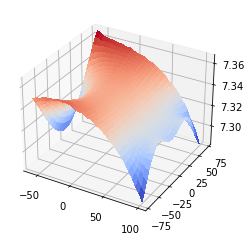

In [6]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(zmesh, ymesh, bzmesh, cmap=cm.coolwarm,linewidth=0, antialiased=False)

Then By.

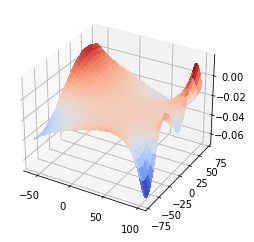

In [7]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(zmesh, ymesh, bymesh, cmap=cm.coolwarm,linewidth=0, antialiased=False)

Those look sensible.

Now our goal is to calculate $(\dfrac{\nabla{}B_{T}}{B_{z}})$ but 

a) we only have values for different y and z

b) we really hope that $B_{x}$ is essentially zero, because of symmetry.

In that case we are going for just dBy/dy, which we can approximate with a simple first difference.

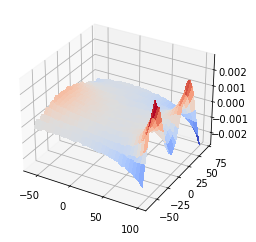

In [9]:
dy = ymesh[1:,:]-ymesh[:-1,:]
dz = zmesh[1:,:]-zmesh[:-1,:]
dy = ymesh[:,1:]-ymesh[:,:-1]
dby = bymesh[:,1:]-bymesh[:,:-1]
dbydy = dby / dy
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(zmesh[:,:-1], ymesh[:,:-1], dbydy, cmap=cm.coolwarm,linewidth=0, antialiased=False)

From that we can go to dBy/dy/Bz, and, for good measure, square the thing to get to the figure of merit.

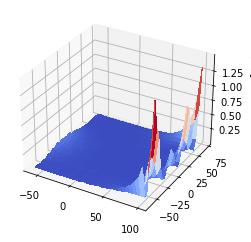

In [10]:
dbb = dbydy / bzmesh[:,:-1]
dbbsq = dbb * dbb
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(zmesh[:,:-1], ymesh[:,:-1], dbbsq, cmap=cm.coolwarm,linewidth=0, antialiased=False)

and I have no idea why JupyterLab has cut the $\times{}10^{-7}$ off the vertical axis.

This can then be weighted by the distance from the axis

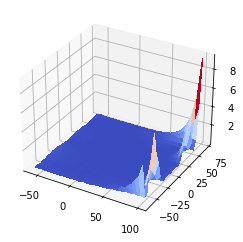

In [12]:
dist = np.abs(ymesh[:,:-1])
wdbb = dbbsq * dist
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(zmesh[:,:-1], ymesh[:,:-1], wdbb, cmap=cm.coolwarm,linewidth=0, antialiased=False)

Then we could extract the area of interest, if I could figure out what that is.

ASSUMING that it is the whole of y and from -55 to +85 in z (indices 1:30) then I get

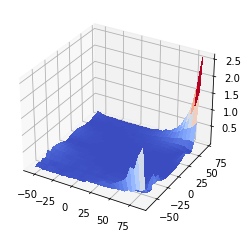

In [14]:
rwdbb = wdbb[1:30,:]
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(zmesh[1:30,:-1], ymesh[1:30,:-1], rwdbb, cmap=cm.coolwarm,linewidth=0, antialiased=False)

So the big problems are in those corners, as we would expect.

To get the full figure of merit we have to sum this and then divide by the right weight.

In [16]:
tot = np.sum(rwdbb)
totweight=np.sum(dist[1:30,:])
print(tot, totweight,tot/totweight, np.sqrt(tot/totweight))

4.434660960084993e-05 28416.429636 1.5605975194247632e-09 3.950439873513788e-05


which is larger than most of Sid's, but not as big as Gordon would expect.

Please criticize!